<a href="https://colab.research.google.com/github/AnthonySunYi/Verilog_DSL/blob/main/stopwatch_Group_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

### FPGA Project  
1. Create a new Vivado project for the Basys 3 FPGA board.  
2. Write Verilog code to implement the stopwatch logic.  
3. Map the Verilog design to the Basys 3 board's resources via the basys3 [constraint file](./Demo_Code/basys3_template.xdc) (`.xdc`).   
4. Generate the bitstream file.
5. Program the FPGA board with the bitstream.  
6. Test and debug your stopwatch design on the FPGA board to ensure correct functionality.  
7. Document your design, including the Verilog code, functional diagrams, and challenges faced during implementation.  
8. **Demo Vivado Project**: [T02_Basys3_StopWatch](./Demo_Code/T02_Basys3_StopWatch)


Design and implement a **stopwatch** on the **Basys 3 FPGA** board using Verilog, making use of the **4-digit** **7-segment** display LEDs for time display. The stopwatch should have the following features:  
1. **Reset functionality**: Press a button (e.g., `btnR`) to restart the stopwatch.  
2. **Time Display**: Display the elapsed time in minutes and seconds on the 4-digit 7-segment display.  
3. **Update Frequency**: Update the display at a reasonable frequency (e.g., every 1 second).

# Seven Segment Display for Basys-3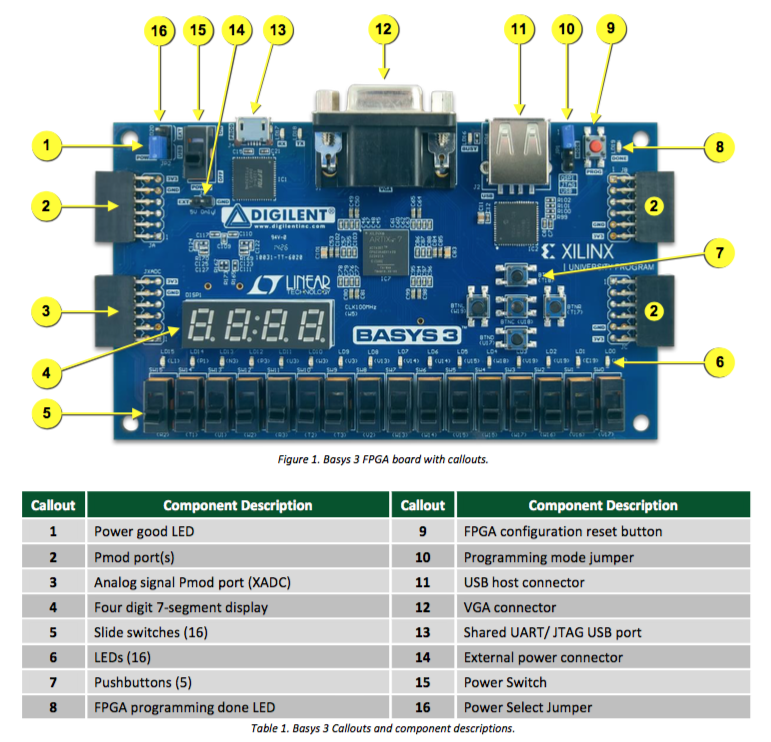

# **Video Demo**
Explantion: In this video we toggle the buttons to showcase the pause and reset functionality
***video***


[link to video demo](https://github.com/LeowYR/DSL_Homework/blob/main/Task02%20Basys%203%20Stopwatch%20Demo.mp4)

# **Logic-gate Code and Testbench**

For the logic gate FPGA, our code and testbench used in the program is shown below.


In [ ]:
%%verilog

// Clock Divider
module clock_divider(
    input clk,         // Fast clock (e.g., 100 MHz)
    input reset,
    output reg clk_1hz
);
    reg [25:0] counter;
    always @(posedge clk or posedge reset) begin
        if (reset) begin
            counter <= 0;
            clk_1hz <= 0;
        end else if (counter == 26'd49_999_999) begin // Fixed to 26-bit
            counter <= 0;
            clk_1hz <= ~clk_1hz;
        end else begin
            counter <= counter + 1;
        end
    end
endmodule

// Debouncer (reintroduced)
module debounce (
    input wire clk,       // Fast clock
    input wire reset,
    input wire button_in,
    output reg button_out
);
    reg [19:0] count;
    reg button_prev;
    always @(posedge clk or posedge reset) begin
        if (reset) begin
            count <= 20'b0;
            button_prev <= 1'b0;
            button_out <= 1'b0;
        end else begin
            button_prev <= button_in;
            if (button_prev != button_in) begin
                count <= 20'b0;
            end else if (count == 20'hFFFFF) begin
                button_out <= button_prev;
            end else begin
                count <= count + 1;
            end
        end
    end
endmodule

// Seven Segment Display (unchanged)
module seven_segment_display(
    input [3:0] digit,
    output reg [6:0] seg
);
    always @(*) begin
        case (digit)
            4'd0: seg = 7'b1000000; // 0
            4'd1: seg = 7'b1111001; // 1
            4'd2: seg = 7'b0100100; // 2
            4'd3: seg = 7'b0110000; // 3
            4'd4: seg = 7'b0011001; // 4
            4'd5: seg = 7'b0010010; // 5
            4'd6: seg = 7'b0000010; // 6
            4'd7: seg = 7'b1111000; // 7
            4'd8: seg = 7'b0000000; // 8
            4'd9: seg = 7'b0010000; // 9
            default: seg = 7'b1111111; // Blank
        endcase
    end
endmodule

module stopwatch(
    input clk,
    input btnC,
    input btnU,
    output reg [3:0] an,
    output reg [6:0] seg
);
    reg [5:0] sec_counter;
    reg [5:0] min_counter;
    reg running;
    wire clk_1hz;
    wire debounced_btnU;
    reg btnU_prev;

    clock_divider clk1 (.clk(clk), .reset(btnC), .clk_1hz(clk_1hz));
    debounce d0 (.clk(clk), .reset(btnC), .button_in(btnU), .button_out(debounced_btnU));

    always @(posedge clk or posedge btnC) begin
        if (btnC) begin
            running <= 0;
            btnU_prev <= 0;
        end else begin
            btnU_prev <= debounced_btnU;
            if (debounced_btnU && !btnU_prev) begin
                running <= ~running;
            end
        end
    end

    always @(posedge clk_1hz or posedge btnC) begin
        if (btnC) begin
            sec_counter <= 6'd0;
            min_counter <= 6'd0;
        end else if (running) begin
            if (sec_counter == 6'd59) begin
                sec_counter <= 6'd0;
                if (min_counter == 6'd59) begin
                    min_counter <= 6'd0;
                end else begin
                    min_counter <= min_counter + 1;
                end
            end else begin
                sec_counter <= sec_counter + 1;
            end
        end
    end

    wire [3:0] min_tens = min_counter / 10;
    wire [3:0] min_ones = min_counter % 10;
    wire [3:0] sec_tens = sec_counter / 10;
    wire [3:0] sec_ones = sec_counter % 10;

    wire [6:0] seg0, seg1, seg2, seg3;
    seven_segment_display seg0_disp(sec_ones, seg0);
    seven_segment_display seg1_disp(sec_tens, seg1);
    seven_segment_display seg2_disp(min_ones, seg2);
    seven_segment_display seg3_disp(min_tens, seg3);

    reg [16:0] mux_clk_div = 0;
    reg mux_clk = 0;
    always @(posedge clk or posedge btnC) begin
        if (btnC) begin
            mux_clk_div <= 0;
            mux_clk <= 0;
        end else if (mux_clk_div == 17'd99_999) begin
            mux_clk_div <= 0;
            mux_clk <= ~mux_clk;
        end else begin
            mux_clk_div <= mux_clk_div + 1;
        end
    end

    reg [1:0] mux_count = 0;
    always @(posedge mux_clk or posedge btnC) begin
        if (btnC) begin
            mux_count <= 0;
            seg <= 7'b1111111; // Blank
            an <= 4'b1111;     // All off
        end else begin
            case (mux_count)
                2'd0: begin seg <= seg0; an <= 4'b1110; end // sec_ones
                2'd1: begin seg <= seg1; an <= 4'b1101; end // sec_tens
                2'd2: begin seg <= seg2; an <= 4'b1011; end // min_ones
                2'd3: begin seg <= seg3; an <= 4'b0111; end // min_tens
            endcase
            mux_count <= mux_count + 1;
        end
    end
endmodule

module tb_stopwatch;
    reg clk;
    reg btnC;
    reg btnU;
    wire [3:0] an;
    wire [6:0] seg;
    wire [3:0] min_tens;
    wire [3:0] min_ones;
    wire [3:0] sec_tens;
    wire [3:0] sec_ones;

    stopwatch uut (
        .clk(clk),
        .btnC(btnC),
        .btnU(btnU),
        .an(an),
        .seg(seg)
    );

    // Clock generation (100 MHz = 10 ns period)
    always
        #5 clk = ~clk;

    // Stimulus
    initial begin
        // Reset
        clk = 0;
        btnC = 1; btnU = 0;

        #20 btnC = 0;          // Release reset after 20 ns

        // Start the stopwatch
        #20_000_000 btnU = 1;  // Press start after 20 ms (exceeds debounce)
        #20_000_000 btnU = 0;  // Release start after 20 ms

        // Run for ~10 seconds
        #10_000_000_000;       // 10 seconds

        // Stop the stopwatch
        #20_000_000 btnU = 1;  // Press stop
        #20_000_000 btnU = 0;  // Release stop

        // Run for another ~5 seconds to verify it stopped
        #5_000_000_000 $finish;
    end

    // Monitor key signals
    initial begin
        $monitor("Time=%0t ns, btnC=%b, btnU=%b, debounced_btnU=%b, running=%b, sec=%d, min=%d, an=%b, seg=%b",
                 $time, btnC, btnU, uut.debounced_btnU, uut.running, uut.sec_counter, uut.min_counter, an, seg);
        $dumpvars(0, tb_stopwatch); // Optional: for waveform viewing
    end
endmodule

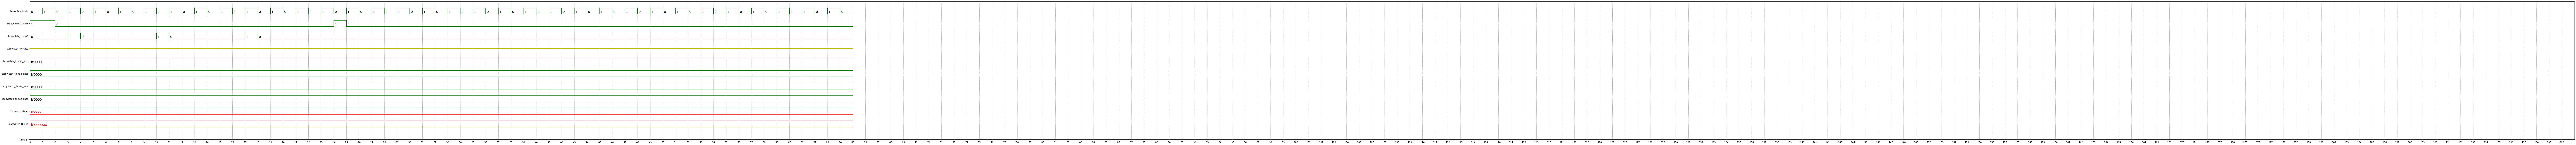

In [ ]:
%%waveform stopwatch_tb.vcd
sign_list = ['stopwatch_tb.clk','stopwatch_tb.btnR','stopwatch_tb.btnC','stopwatch_tb.state','stopwatch_tb.min_tens','stopwatch_tb.min_ones','stopwatch_tb.sec_tens','stopwatch_tb.sec_ones','stopwatch_tb.an','stopwatch_tb.seg']
time_begin = 0
time_end = 200
base = 'bin'

In [ ]:
%%verilog
module clock_divider(
    input clk,        // 100MHz system clock
    input reset,
    output reg clk_1hz
);
    reg [25:0] counter;
    always @(posedge clk or posedge reset) begin
        if (reset) begin
            counter <= 0;
            clk_1hz <= 0;
        end else if (counter == 26'd49_999_999) begin
            counter <= 0;
            clk_1hz <= ~clk_1hz;
        end else begin
            counter <= counter + 1;
        end
    end
endmodule

//----TESTBENCH----
module stopwatch_tb;
    reg clk;
    reg btnR;
    reg btnC;
    wire state;
    wire [3:0] min_tens;
    wire [3:0] min_ones;
    wire [3:0] sec_tens;
    wire [3:0] sec_ones;
    wire [3:0] an;
    wire [6:0] seg;

    // Instantiate the stopwatch module
    stopwatch uut (
        .clk(clk),
        .btnR(btnR),
        .btnC(btnC),
        .state(state),
        .min_tens(min_tens),
        .min_ones(min_ones),
        .sec_tens(sec_tens),
        .sec_ones(sec_ones),
        .an(an),
        .seg(seg)
    );

    // Proper Clock Generation
    always #1 clk = ~clk;  // Toggle clock every 1 time unit

    initial begin
        $dumpfile("stopwatch_tb.vcd");
        $dumpvars(0, stopwatch_tb);
        $dumpon;

        // Initialize inputs
        clk = 0;
        btnR = 1;
        btnC = 0;
        #2;  // Hold reset for some time
        btnR = 0;

        // Start the stopwatch
        #1 btnC = 1;
        #1 btnC = 0; // Simulating button press

        // Wait for a few simulated seconds
        #5;

        // Pause the stopwatch
        #1 btnC = 1;
        #1 btnC = 0;

        // Wait and observe display
        #5;

        // Resume the stopwatch
        #1 btnC = 1;
        #1 btnC = 0;

        // Run for more simulated seconds
        #5;

        // Reset the stopwatch
        #1 btnR = 1;
        #1 btnR = 0;

        // End simulation
        #40;
        $dumpoff;
        $finish;
    end
endmodule

module debounce(
    input wire clk,
    input wire reset,
    input wire button_in,
    output reg button_out
);
    reg [19:0] count;
    reg button_prev;
    always @(posedge clk or posedge reset) begin
        if (reset) begin
            count <= 0;
            button_prev <= 0;
            button_out <= 0;
        end else begin
            button_prev <= button_in;
            if (button_prev != button_in) begin
                count <= 0;
            end else if (count == 20'hFFFFF) begin
                button_out <= button_prev;
            end else begin
                count <= count + 1;
            end
        end
    end
endmodule

module seven_segment_display(
    input [3:0] digit,
    output reg [6:0] seg
);
    always @(*) begin
        case (digit)
            4'd0: seg = 7'b1000000;
            4'd1: seg = 7'b1111001;
            4'd2: seg = 7'b0100100;
            4'd3: seg = 7'b0110000;
            4'd4: seg = 7'b0011001;
            4'd5: seg = 7'b0010010;
            4'd6: seg = 7'b0000010;
            4'd7: seg = 7'b1111000;
            4'd8: seg = 7'b0000000;
            4'd9: seg = 7'b0010000;
            default: seg = 7'b1111111;
        endcase
    end
endmodule

module stopwatch(
    input clk,
    output state,
    output [3:0] min_tens,
    output [3:0] min_ones,
    output [3:0] sec_tens,
    output [3:0] sec_ones,
    input btnR,
    input btnC,
    output reg [3:0] an,
    output reg [6:0] seg
);
    reg [5:0] seconds;
    reg [6:0] minutes;
    reg running;
    wire clk_1hz;
    wire debounced_btnC;

    clock_divider clk1 (.clk(clk), .reset(btnR), .clk_1hz(clk_1hz));
    debounce db (.clk(clk), .reset(btnR), .button_in(btnC), .button_out(debounced_btnC));

    always @(posedge clk_1hz or posedge btnR) begin
        if (btnR) begin
            seconds <= 0;
            minutes <= 0;
            running <= 0;
        end else if (debounced_btnC) begin
            running <= ~running;
        end
        if (running) begin
            if (seconds == 59) begin
                seconds <= 0;
                if (minutes == 99)
                    minutes <= 0;
                else
                    minutes <= minutes + 1;
            end else begin
                seconds <= seconds + 1;
            end
        end
    end

    wire [3:0] min_tens = minutes / 10;
    wire [3:0] min_ones = minutes % 10;
    wire [3:0] sec_tens = seconds / 10;
    wire [3:0] sec_ones = seconds % 10;

    wire [6:0] seg0, seg1, seg2, seg3;
    seven_segment_display s0 (sec_ones, seg0);
    seven_segment_display s1 (sec_tens, seg1);
    seven_segment_display s2 (min_ones, seg2);
    seven_segment_display s3 (min_tens, seg3);

    reg [16:0] mux_clk_div;
    reg mux_clk;
    always @(posedge clk) begin
        if (mux_clk_div == 17'd99_999) begin
            mux_clk_div <= 0;
            mux_clk <= ~mux_clk;
        end else begin
            mux_clk_div <= mux_clk_div + 1;
        end
    end

    reg [1:0] mux_count = 0;
    always @(posedge mux_clk) begin
        case (mux_count)
            2'd0: begin seg <= seg0; an <= 4'b1110; end
            2'd1: begin seg <= seg1; an <= 4'b1101; end
            2'd2: begin seg <= seg2; an <= 4'b1011; end
            2'd3: begin seg <= seg3; an <= 4'b0111; end
        endcase
        mux_count <= mux_count + 1;
    end
endmodule


VCD info: dumpfile stopwatch_tb.vcd opened for output.



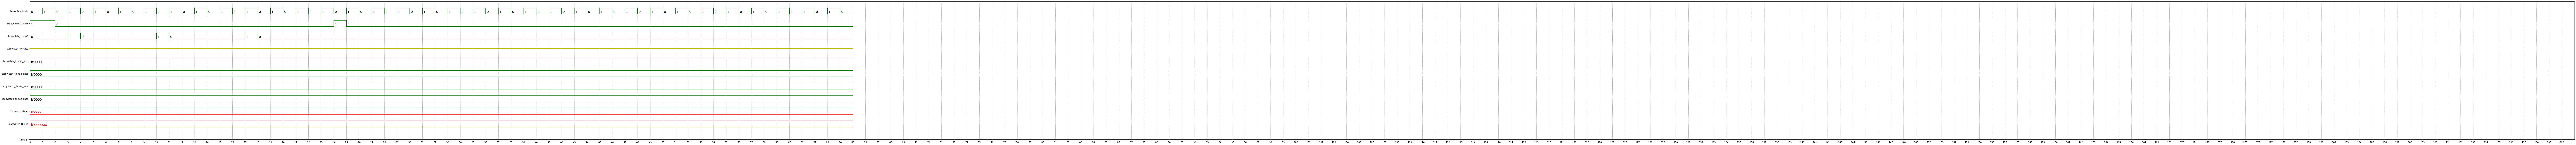

In [ ]:
%%waveform stopwatch_tb.vcd
sign_list = ['stopwatch_tb.clk','stopwatch_tb.btnR','stopwatch_tb.btnC','stopwatch_tb.state','stopwatch_tb.min_tens','stopwatch_tb.min_ones','stopwatch_tb.sec_tens','stopwatch_tb.sec_ones','stopwatch_tb.an','stopwatch_tb.seg']
time_begin = 0
time_end = 200
base = 'bin'


The code is divided into 3 sections, the clock divider, seven_segment display and debouncer for the buttons.

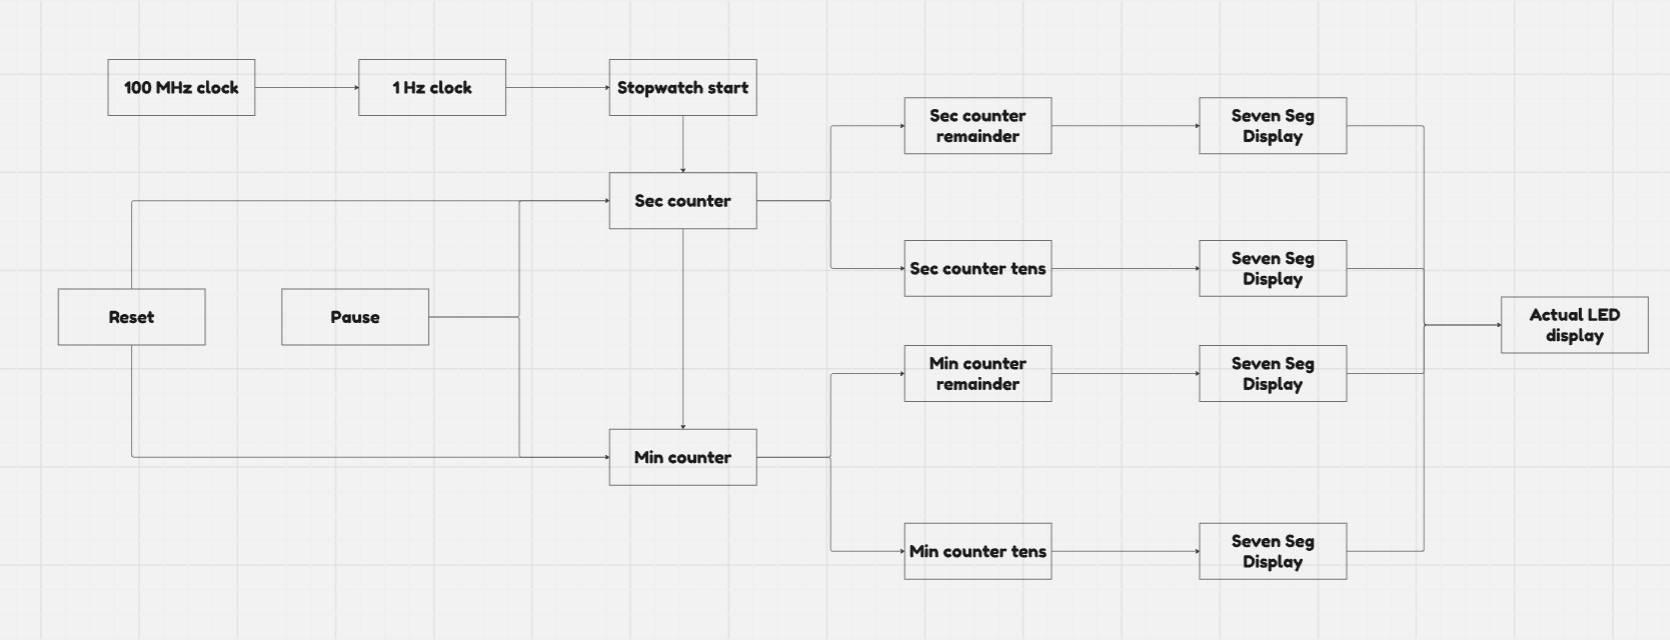

Fig 1 Block diagram for code

Our code can be seen more easily with the block diagram above, I will be tackling the other unseen elements that make the code work below.

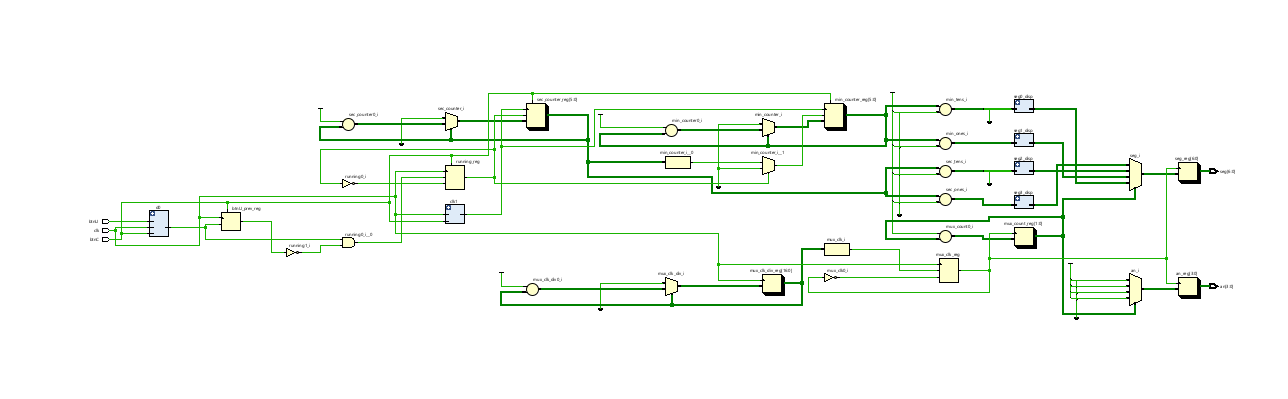

Fig 2 Linter diagram

# Clock Divider

As the Clock of the FPGA is set to 100MHz, we needed to bring the clk down to 1Hz for our stopwatch to work. As such, a clock divider was used where each time the clk was high, the counter would increase by 1 to 100M, where it would output a 1 for the 1Hz_Clk. Thus we were able to use the 100MHz clk as a 1Hz clk.

# Seven_segment display
We included this module as a way for us to split our 4 time data into 1 update at a time, allowing us to send the data required to the specific cell and specific value at a time.

# Debouncer

To enable the buttons to work for the pause and reset, a debouncer would be required to allow the bits to remain as required.

# Constraints

We then inputted this into Vivado, allowing for the Seg, an, as well as BtnC and
BtnU to be unconstrainted as inputs for the FPGA.

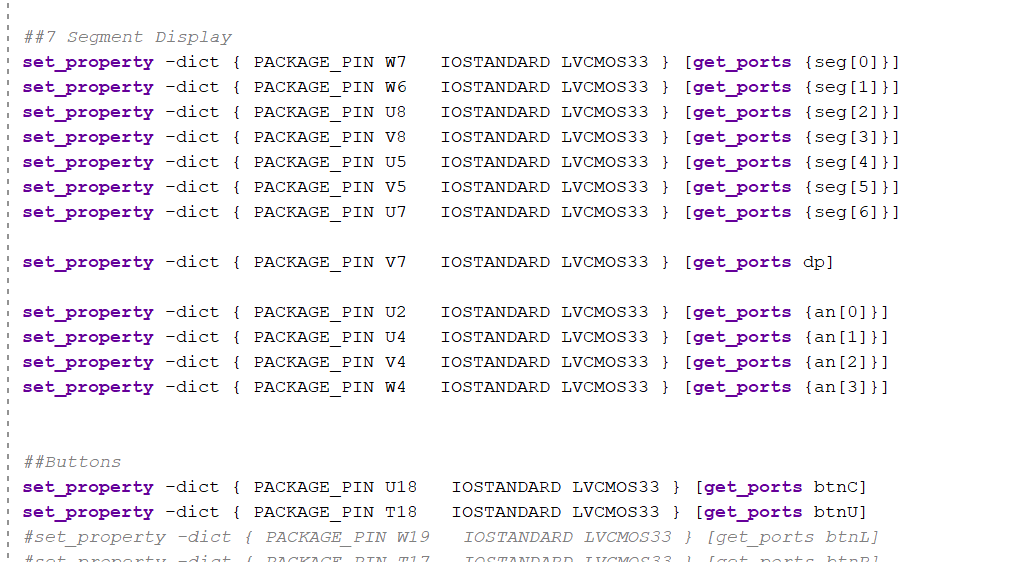


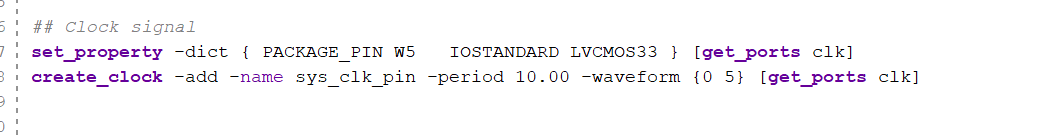
Fig 3 and 4 Constraints file

We then generated a bit-stream and tested the Code in the FPGA as seen in the video above.

# Usage of AI and Design challenges



We primarily used AI to help us with understanding the need of a multiplexor and the implementation of it.

Before using a multiplexor, we came across the problem whereby the output could only represent one digit’s pattern at a time. The other digits would either show the same pattern or be blank, making it impossible to display different values (e.g., "12:34") simultaneously.

In order to display all four digits "simultaneously" on a shared seven-segment display, we need to cycle through them rapidly, activating one digit at a time while sending the appropriate segment pattern (seg[6:0]) for that digit. Each digit is turned on briefly in sequence, and the switching happens very quickly that it appears as if all four digits are lit simultaneously.

The multiplexing clock (mux_clk) is derived by dividing the fast input clock (100 MHz) down to approximately 1 kHz (using mux_clk_div == 17'd99_999). This means each digit is refreshed about 250 times per second (1 kHz / 4 digits = 250 Hz per digit).



> Add blockquote

